<a href="https://colab.research.google.com/github/daniel8691/rental-housing-toronto/blob/master/rent_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np

In [6]:
url = "https://dataviz-class-1-dt.s3.us-east-2.amazonaws.com/transposed_complete_df.csv"
rental_df = pd.read_csv(url)

In [11]:
rental_df.head()


,postal_code,cluster_labels,geocode_lat,geocode_lng,address,num_sqft,rent,num_bathrooms,price_per_sqft,metro_station,train_station,bus_station,bus_stop,shopping_mall,shopping_plaza,grocery_store
0,M1H,2,43.781624,-79.247376,"36 Lee Centre Drive, Toronto",750.0,1925.0,1.0,2.566667,5609,4931,3924,2912,17655,8666,3345
1,M1H,2,43.781660,-79.247547,"38 Lee Centre Drive, Toronto",650.0,1950.0,1.0,3.000000,5610,4944,3921,2916,17644,8651,3335
2,M1H,2,43.781661,-79.245271,"11 Lee Centre Drive, Toronto",650.0,1950.0,1.0,3.000000,5655,4799,4011,2915,17815,8816,3493
3,M1H,2,43.780832,-79.247346,"8 Lee Centre Drive, Toronto",650.0,1850.0,1.0,2.846154,5524,4876,3848,2823,17627,8707,3303
4,M1H,2,43.773869,-79.249988,"88 Grangeway Avenue, Toronto",650.0,2000.0,1.0,3.076923,4721,4652,3074,2070,17170,8896,2796


In [16]:
# find out the bathroom numbers for units 
rental_df['num_bathrooms'].unique()

array([1. , 0.5, 2. , 1.5, 0. , 3. ])

In [19]:

rental_df.columns.values

array(['postal_code', 'cluster_labels', 'geocode_lat', 'geocode_lng',
       'address', 'num_sqft', 'rent', 'num_bathrooms', 'price_per_sqft',
       'metro_station', 'train_station', 'bus_station', 'bus_stop',
       'shopping_mall', 'shopping_plaza', 'grocery_store'], dtype=object)

In [21]:
# move rent to the very first column
rental_df = rental_df[['rent','num_sqft', 'num_bathrooms',
       'metro_station', 'train_station', 'bus_station', 'bus_stop',
       'shopping_mall', 'shopping_plaza', 'grocery_store']]
rental_df.head()

,rent,num_sqft,num_bathrooms,metro_station,train_station,bus_station,bus_stop,shopping_mall,shopping_plaza,grocery_store
0,1925.0,750.0,1.0,5609,4931,3924,2912,17655,8666,3345
1,1950.0,650.0,1.0,5610,4944,3921,2916,17644,8651,3335
2,1950.0,650.0,1.0,5655,4799,4011,2915,17815,8816,3493
3,1850.0,650.0,1.0,5524,4876,3848,2823,17627,8707,3303
4,2000.0,650.0,1.0,4721,4652,3074,2070,17170,8896,2796


In [22]:
predictors = rental_df.iloc[:,1:]
predictors.head()


,num_sqft,num_bathrooms,metro_station,train_station,bus_station,bus_stop,shopping_mall,shopping_plaza,grocery_store
0,750.0,1.0,5609,4931,3924,2912,17655,8666,3345
1,650.0,1.0,5610,4944,3921,2916,17644,8651,3335
2,650.0,1.0,5655,4799,4011,2915,17815,8816,3493
3,650.0,1.0,5524,4876,3848,2823,17627,8707,3303
4,650.0,1.0,4721,4652,3074,2070,17170,8896,2796


In [38]:
X = predictors.values
y = rental_df['rent'].values

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [41]:
from sklearn.preprocessing import MinMaxScaler

In [42]:
scaler = MinMaxScaler()

In [43]:
X_train = scaler.fit_transform(X_train)
# don't fit the test set because we don't want to assume prior information about the test set
X_test = scaler.transform(X_test)

In [44]:
# sequential model
from tensorflow.keras.models import Sequential
# Dense layers
from tensorflow.keras.layers import Dense

In [45]:
# check that the dataset has 80% training and 20% testing data
X_train.shape[0] / X.shape[0]

0.8

In [46]:
X_train.shape

(668, 9)

In [102]:
model = Sequential()

model.add(Dense(9, activation='relu'))
model.add(Dense(9, activation='relu'))
# model.add(Dense(9, activation='relu'))
# model.add(Dense(9, activation='relu'))

# one more layer with just one neuron since this is outputting the predicted price
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mae')


In [103]:
# train the model
# check with test set as we train using the validation_data parameter
model.fit(x=X_train, y=y_train, 
          validation_data = (X_test, y_test),
          # set batch size so we don't pass in the entire training set at once (prevent overfitting)
          # focus on smaller batch
          batch_size = 128,
          # run 400 times
          epochs = 900)

Epoch 1/900
6/6 [==============================] - 0s 22ms/step - loss: 2123.3208 - val_loss: 2128.4683
Epoch 2/900
6/6 [==============================] - 0s 5ms/step - loss: 2123.2375 - val_loss: 2128.3833
Epoch 3/900
6/6 [==============================] - 0s 5ms/step - loss: 2123.1484 - val_loss: 2128.2927
Epoch 4/900
6/6 [==============================] - 0s 5ms/step - loss: 2123.0522 - val_loss: 2128.1938
Epoch 5/900
6/6 [==============================] - 0s 7ms/step - loss: 2122.9482 - val_loss: 2128.0879
Epoch 6/900
6/6 [==============================] - 0s 5ms/step - loss: 2122.8376 - val_loss: 2127.9741
Epoch 7/900
6/6 [==============================] - 0s 5ms/step - loss: 2122.7188 - val_loss: 2127.8530
Epoch 8/900
6/6 [==============================] - 0s 5ms/step - loss: 2122.5923 - val_loss: 2127.7231
Epoch 9/900
6/6 [==============================] - 0s 5ms/step - loss: 2122.4573 - val_loss: 2127.5842
Epoch 10/900
6/6 [==============================] - 0s 7ms/step - loss: 

In [104]:
# get a history of the losses
# model.history.history

# put the loss history in a dataframe for better visualization
losses = pd.DataFrame(model.history.history, columns = ["training_loss", "val_loss"])

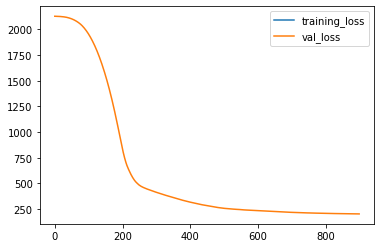

In [105]:
losses.plot()

We can see a decrease in both the training loss and the validation loss . There is no visible increase in the validation set, which means we can technically continued training

In [106]:
from sklearn.metrics import mean_squared_error,mean_absolute_error, explained_variance_score

In [107]:
predictions = model.predict(X_test)

In [108]:
mse = mean_squared_error(y_test, predictions)
mse

76302.32811851558

In [109]:
# mean absolute error
mae = mean_absolute_error(y_test, predictions)
mae

202.64927225626872

In [110]:
rental_df['rent'].describe()

count     835.000000
mean     2125.008383
std       363.559143
min      1000.000000
25%      1937.500000
50%      2100.000000
75%      2287.500000
max      8495.000000
Name: rent, dtype: float64

In [111]:
mae / rental_df['rent'].mean()

0.09536398719891453

to see if the MAE is at the right level, find the mean of the dependent variable and see what percentage of the mae is compared to the mean, in this case, (mae / 2125 = 8.91%). 

Use the "explained_variance_score" function from the sklearn library to get a better understanding of what's happening. (best possible score is 1.0). It tells us how much variance is explained by the model.

In [100]:
explained_variance_score(y_test, predictions)

0.30108721590193543

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


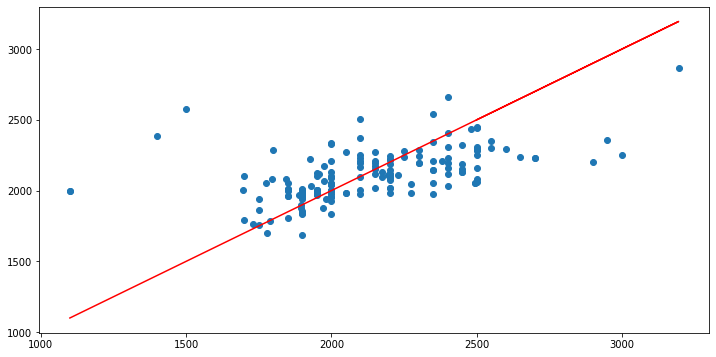

In [101]:
plt.figure(figsize=(12,6))
plt.scatter(y_test,predictions)
# plot the perfect prediction line
plt.plot(y_test,y_test,'r')

In [80]:
rental_df.head()

,rent,num_sqft,num_bathrooms,metro_station,train_station,bus_station,bus_stop,shopping_mall,shopping_plaza,grocery_store
0,1925.0,750.0,1.0,5609,4931,3924,2912,17655,8666,3345
1,1950.0,650.0,1.0,5610,4944,3921,2916,17644,8651,3335
2,1950.0,650.0,1.0,5655,4799,4011,2915,17815,8816,3493
3,1850.0,650.0,1.0,5524,4876,3848,2823,17627,8707,3303
4,2000.0,650.0,1.0,4721,4652,3074,2070,17170,8896,2796


In [85]:
single_property = rental_df.iloc[0,1:]

In [87]:
# can't just put the data in the model because it's not scaled and in the right shape
single_property.values.reshape(-1, 9)

array([[7.5000e+02, 1.0000e+00, 5.6090e+03, 4.9310e+03, 3.9240e+03,
        2.9120e+03, 1.7655e+04, 8.6660e+03, 3.3450e+03]])

In [88]:
single_property = scaler.transform(single_property.values.reshape(-1,9))

In [89]:
model.predict(single_property)

array([[2049.1172]], dtype=float32)

In [90]:
rental_df.head(1)

,rent,num_sqft,num_bathrooms,metro_station,train_station,bus_station,bus_stop,shopping_mall,shopping_plaza,grocery_store
0,1925.0,750.0,1.0,5609,4931,3924,2912,17655,8666,3345


the predicted value is off by around $124

dropout layers: can be added to layers to "turn off" neurons udring training to prevent overfitting. Each dropout layer will 'drop' a user-defined percentage of neuron units in the previous layer every batch

EarlyStopping: verbose=1 to get a report back, and patience=25 which waits 25 epochs even after a stopping point is determined.

In [124]:
model = Sequential()

model.add(Dense(9, activation='relu'))
model.add(Dense(9, activation='relu'))
model.add(Dense(9, activation='relu'))
model.add(Dense(9, activation='relu'))

# one more layer with just one neuron since this is outputting the predicted price
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mae')


In [125]:
from tensorflow.keras.callbacks import EarlyStopping

In [129]:
# monitor if the network doesn't import for 25 consecutive epochs than stop training
es = EarlyStopping(monitor='val_loss', patience=25, mode='min')

# train the model
# check with test set as we train using the validation_data parameter
model.fit(x=X_train, y=y_train, 
          validation_data = (X_test, y_test),
          # set batch size so we don't pass in the entire training set at once (prevent overfitting)
          # focus on smaller batch
          batch_size = 128,
          callbacks=[es],
          epochs = 1800)

Epoch 1/1800
6/6 [==============================] - 0s 11ms/step - loss: 238.3545 - val_loss: 227.4117
Epoch 2/1800
6/6 [==============================] - 0s 5ms/step - loss: 236.9612 - val_loss: 224.2616
Epoch 3/1800
6/6 [==============================] - 0s 5ms/step - loss: 236.0768 - val_loss: 222.8395
Epoch 4/1800
6/6 [==============================] - 0s 7ms/step - loss: 235.1073 - val_loss: 222.4955
Epoch 5/1800
6/6 [==============================] - 0s 5ms/step - loss: 234.2412 - val_loss: 222.3056
Epoch 6/1800
6/6 [==============================] - 0s 6ms/step - loss: 233.4361 - val_loss: 221.5361
Epoch 7/1800
6/6 [==============================] - 0s 6ms/step - loss: 232.5942 - val_loss: 221.4185
Epoch 8/1800
6/6 [==============================] - 0s 5ms/step - loss: 231.8171 - val_loss: 220.6940
Epoch 9/1800
6/6 [==============================] - 0s 5ms/step - loss: 231.0091 - val_loss: 219.9812
Epoch 10/1800
6/6 [==============================] - 0s 6ms/step - loss: 230.1866

In [130]:
new_losses = pd.DataFrame(model.history.history,columns=['training_loss', 'val_loss'])

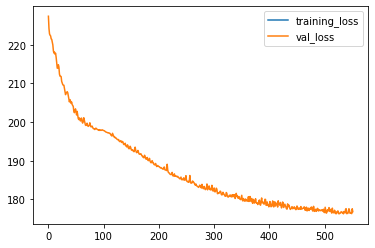

In [131]:
new_losses.plot()

In [116]:
new_predictions = model.predict(X_test)

In [118]:
mae = mean_absolute_error(y_test, new_predictions)
mae

175.93110556231287

In [132]:
mae / rental_df['rent'].mean()

0.08279078188604891

In [134]:
explained_variance_score(y_test, new_predictions)

0.29955843375187796

try to see if taking out outliers can help with the model's accuracy. i'll use IQR

In [136]:
Q1 = rental_df['rent'].quantile(0.25)
Q3 = rental_df['rent'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

350.0


In [140]:
outliers_df = rental_df.loc[(rental_df['rent'] < (Q1 - 1.5*IQR)) |\
              (rental_df['rent'] > (Q3 + 1.5*IQR))]

In [148]:
outliers_df.head()

,rent,num_sqft,num_bathrooms,metro_station,train_station,bus_station,bus_stop,shopping_mall,shopping_plaza,grocery_store
159,3000.0,800.0,1.0,8230,8454,1952,1611,7797,15710,7463
203,1000.0,300.0,1.0,6626,6691,4694,3400,5474,12958,4802
221,3700.0,850.0,2.0,4041,4096,3636,1975,3022,15439,2269
259,2950.0,700.0,2.0,2335,2399,1071,897,1318,16987,645
262,3200.0,700.0,1.0,2332,2391,1064,940,1320,17006,669


In [155]:
filtered_df = rental_df.loc[~rental_df.index.isin(outliers_df.index)]

In [156]:
print(rental_df.shape)
print(outliers_df.shape)
print(filtered_df.shape)

(835, 10)
(26, 10)
(809, 10)


In [158]:
filtered_df.head()

,rent,num_sqft,num_bathrooms,metro_station,train_station,bus_station,bus_stop,shopping_mall,shopping_plaza,grocery_store
0,1925.0,750.0,1.0,5609,4931,3924,2912,17655,8666,3345
1,1950.0,650.0,1.0,5610,4944,3921,2916,17644,8651,3335
2,1950.0,650.0,1.0,5655,4799,4011,2915,17815,8816,3493
3,1850.0,650.0,1.0,5524,4876,3848,2823,17627,8707,3303
4,2000.0,650.0,1.0,4721,4652,3074,2070,17170,8896,2796


In [160]:
filtered_df.iloc[:,1:].values

array([[7.5000e+02, 1.0000e+00, 5.6090e+03, ..., 1.7655e+04, 8.6660e+03,
        3.3450e+03],
       [6.5000e+02, 1.0000e+00, 5.6100e+03, ..., 1.7644e+04, 8.6510e+03,
        3.3350e+03],
       [6.5000e+02, 1.0000e+00, 5.6550e+03, ..., 1.7815e+04, 8.8160e+03,
        3.4930e+03],
       ...,
       [6.8800e+02, 1.0000e+00, 2.1750e+03, ..., 3.1470e+03, 2.3750e+04,
        4.0200e+02],
       [7.4300e+02, 2.0000e+00, 3.6400e+03, ..., 3.8300e+02, 2.5042e+04,
        8.1400e+02],
       [6.8500e+02, 1.0000e+00, 4.8930e+03, ..., 6.4430e+03, 1.7689e+04,
        5.3030e+03]])

In [161]:
X2 = filtered_df.iloc[:,1:].values
y2 = filtered_df['rent'].values

In [166]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2, test_size=0.2, random_state=42)

In [167]:
scaler = MinMaxScaler()

In [168]:
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

In [169]:
X_train2.shape[0] / filtered_df.shape[0]

0.799752781211372

In [170]:
model = Sequential()

model.add(Dense(9, activation='relu'))
model.add(Dense(9, activation='relu'))
model.add(Dense(9, activation='relu'))
model.add(Dense(9, activation='relu'))

# one more layer with just one neuron since this is outputting the predicted price
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mae')

In [171]:
# monitor if the network doesn't import for 25 consecutive epochs than stop training
es = EarlyStopping(monitor='val_loss', patience=25, mode='min')

# train the model
# check with test set as we train using the validation_data parameter
model.fit(x=X_train2, y=y_train2, 
          validation_data = (X_test2, y_test2),
          # set batch size so we don't pass in the entire training set at once (prevent overfitting)
          # focus on smaller batch
          batch_size = 128,
          callbacks=[es],
          epochs = 1800)

Epoch 1/1800
6/6 [==============================] - 0s 24ms/step - loss: 2102.5857 - val_loss: 2124.4626
Epoch 2/1800
6/6 [==============================] - 0s 6ms/step - loss: 2102.5557 - val_loss: 2124.4312
Epoch 3/1800
6/6 [==============================] - 0s 5ms/step - loss: 2102.5234 - val_loss: 2124.3962
Epoch 4/1800
6/6 [==============================] - 0s 5ms/step - loss: 2102.4883 - val_loss: 2124.3577
Epoch 5/1800
6/6 [==============================] - 0s 5ms/step - loss: 2102.4485 - val_loss: 2124.3135
Epoch 6/1800
6/6 [==============================] - 0s 5ms/step - loss: 2102.4031 - val_loss: 2124.2627
Epoch 7/1800
6/6 [==============================] - 0s 5ms/step - loss: 2102.3503 - val_loss: 2124.2041
Epoch 8/1800
6/6 [==============================] - 0s 7ms/step - loss: 2102.2898 - val_loss: 2124.1355
Epoch 9/1800
6/6 [==============================] - 0s 6ms/step - loss: 2102.2180 - val_loss: 2124.0544
Epoch 10/1800
6/6 [==============================] - 0s 5ms/ste

In [172]:
predictions2 = model.predict(X_test2)

In [175]:
mae = mean_absolute_error(y_test2, predictions2)
mae

173.16488609784915

In [176]:
explained_variance_score(y_test2, predictions2)

0.13536526773384006

In [180]:
losses2 = pd.DataFrame(model.history.history,columns=['training_loss', 'val_loss'])

In [181]:
losses2.plot()

TypeError: ignored

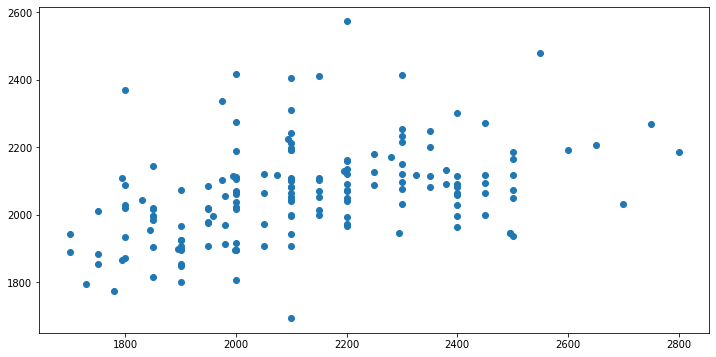

In [179]:
plt.figure(figsize=(12,6))
plt.scatter(y_test2,predictions2)
